[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/analytics-and-ml/model-training/training-with-wandb/01-encoder-train.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/analytics-and-ml/model-training/training-with-wandb/01-encoder-train.ipynb)

In [ ]:
!pip install -qq wandb datasets pinecone-client sentence-transformers transformers

## Encoder Training

This is part *two* of a four-part notebook series on fine-tuning encoder models with Weights & Biases for use with Pinecone. Find the [full set of notebooks on Github here](https://github.com/pinecone-io/examples/blob/master/analytics-and-ml/model-training/training-with-wandb).

We begin by initializing our connection to W&B, if you need an API key they can be found (for free) at [WandB.ai](https://wandb.ai). If you haven't already created the project, the following will create a new project called `arxiv-searching`.

In [ ]:
import wandb
run = wandb.init(project="arxiv-searching")

/opt/conda/lib/python3.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
wandb: Currently logged in as: jamesbriggs. Use `wandb login --relogin` to force relogin


We begin by downloading what will be our train and validation datasets generated by the **T5** model in this [previous notebook from W&B](https://colab.research.google.com/drive/1IemM772X54ND--WtEx61ENMTzeVv17eu?usp=sharing). Both of these exist as artifacts in W&B:

In [ ]:
train_artifact = run.use_artifact(
    'events/arxiv-searching/arxiv-papers:latest', type='dataset'
)
train_artifact_dir = train_artifact.download()
val_artifact = run.use_artifact(
    'events/arxiv-searching/arxiv-predictions:latest', type='test_dataset_w_predictions'
)
val_artifact_dir = val_artifact.download()

wandb: Downloading large artifact arxiv-papers:latest, 3388.22MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.1
wandb:   1 of 1 files downloaded.  


These are downloaded to two directories:

In [ ]:
train_artifact_dir

'./artifacts/arxiv-papers:v0'

In [ ]:
import os

os.listdir(train_artifact_dir), os.listdir(val_artifact_dir)

(['arxiv-snapshot'], ['.ipynb_checkpoints', 'arxiv-test-dataset'])

The train file is a *huge* JSON lines with ~2M+ rows, whereas the validation file is a small ~1000 line CSV. We can load them like so:

In [ ]:
import pandas as pd
import json

train_path = train_artifact_dir+"/"+os.listdir(train_artifact_dir)[-1]
val_path = val_artifact_dir+"/"+os.listdir(val_artifact_dir)[-1]

def load_json_lines(path):
    with open(path, 'r') as f:
        for line in f:
            line_dict = json.loads(line)
            yield line_dict

train_metadata = load_json_lines(train_path)
val_metadata = pd.read_csv(val_path)

We keep the training set as a generator function rather than loading it all into memory at once.

In [ ]:
train_metadata

<generator object load_json_lines at 0x7f82d0cb35d0>

In [ ]:
# Show us a single item
for doc in train_metadata:
    print(doc)
    break

{'id': '0704.0001', 'submitter': 'Pavel Nadolsky', 'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan", 'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies', 'comments': '37 pages, 15 figures; published version', 'journal-ref': 'Phys.Rev.D76:013009,2007', 'doi': '10.1103/PhysRevD.76.013009', 'report-no': 'ANL-HEP-PR-07-12', 'categories': 'hep-ph', 'license': None, 'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with data from the Fermilab

Our validation set is tiny so we load it all in-memory as a Pandas dataframe:

In [ ]:
val_metadata.head()

,Unnamed: 0,doi,year,cat_all,target_text,input_text,summarized_new_title
0,4384,10.1145/3472538.3472587,2021,"['cs.LG', 'cs.AI']",Adversarial Random Forest Classifier for Autom...,"Autonomous game design, generating games algor...",Random Forest Classifier for Automated Game De...
1,4741,10.4204/EPTCS.345,2021,"['cs.LO', 'cs.AI']",Proceedings 37th International Conference on L...,ICLP is the premier international event for pr...,Proceedings 37th International Conference on L...
2,5127,10.1103/PhysRevLett.127.237401,2021,"['cond-mat.other', 'cond-mat.mtrl-sci']",Natural Negative-Refractive-Index Materials,Our calculation shows that negative refractive...,Natural Negative-Refractive-Index Materials
3,2463,NaN,2021,"['math.NA', 'cs.NA']",Quartic $L^p$-convergence of cubic Riemannian ...,We prove quartic convergence of cubic spline i...,Convergence of cubic Riemannian splines
4,4101,10.1103/PhysRevD.104.L121301,2021,['astro-ph.CO'],Model-independent versus model-dependent inter...,The traditional clustering analyses of galaxy ...,Bridging the Gap Between Model-Independent and...
...,...,...,...,...,...,...,...
1108,4130,NaN,2021,"['cs.LG', 'stat.ML']",Multitask Learning for Citation Purpose Classi...,We present our entry into the 2021 3C Shared T...,Multitask Learning for Citation Purpose Classi...
1109,1398,10.1007/978-3-030-93413-2_29,2021,"['cs.SI', 'cs.LG']",Towards control of opinion diversity by introd...,We explore a method to influence or even contr...,Control of opinion diversity by introducing ze...
1110,4919,NaN,2021,['cs.CR'],Privacy-Preserving Mutual Authentication and K...,The usage of different technologies and smart ...,Privacy-Preserving Key Agreement Scheme for Mu...
1111,1606,10.1137/20M1354982,2021,"['cs.LG', 'eess.IV', 'eess.SP', 'stat.ML']",Simplex-Structured Matrix Factorization: Spars...,"In this paper, we provide novel algorithms wit...",Simplex-Structured Matrix Factorization: Spars...


The equivalent features that we care about here are:

| train | val |
| ----- | --- |
| `abstract` | `input_text` |
| `title` | `summarized_new_title` |

In [ ]:
val_metadata.iloc[0]

Unnamed: 0                                                           4384
doi                                               10.1145/3472538.3472587
year                                                                 2021
cat_all                                                ['cs.LG', 'cs.AI']
target_text             Adversarial Random Forest Classifier for Autom...
input_text              Autonomous game design, generating games algor...
summarized_new_title    Random Forest Classifier for Automated Game De...
Name: 0, dtype: object

We want the `title` and `abstract` (or equivalent) to act as our *anchor*, *positive* pair respectively. To do this we will create a dataset object that will handle loading these values in the required format.

In [ ]:
from transformers import AutoTokenizer
import torch

model_id = 'microsoft/MiniLM-L12-H384-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_id)

class ArxivDataset(torch.utils.data.IterableDataset):
    def __init__(self, data_gen):
        super(ArxivDataset).__init__()
        # this depends on your dataset, suppose your dataset contains 
        # images whose path you save in this list
        self.dataset = data_gen

    def __iter__(self):
        for doc in self.dataset:
            anchor = tokenizer(
                doc['title'], max_length=512,
                padding='max_length', truncation=True,
                return_tensors='pt'
            )
            positive = tokenizer(
                doc['abstract'], max_length=512,
                padding='max_length', truncation=True,
                return_tensors='pt'
            )
            sample = {
                'anchor': {
                    'input_ids': anchor['input_ids'],
                    'attention_mask': anchor['attention_mask']
                },
                'positive': {
                    'input_ids': positive['input_ids'],
                    'attention_mask': positive['attention_mask']
                }
            }
            yield sample

class ArxivValDataset(torch.utils.data.Dataset):
    def __init__(self, val_df):
        self.df = val_df
        
    def __getitem__(self, idx):
        doc = self.df.iloc[idx]
        anchor = tokenizer(
            doc['summarized_new_title'], max_length=512,
            padding='max_length', truncation=True,
            return_tensors='pt'
        )
        positive = tokenizer(
            doc['input_text'], max_length=512,
            padding='max_length', truncation=True,
            return_tensors='pt'
        )
        sample = {
            'anchor': {
                'input_ids': anchor['input_ids'],
                'attention_mask': anchor['attention_mask']
            },
            'positive': {
                'input_ids': positive['input_ids'],
                'attention_mask': positive['attention_mask']
            }
        }
        return sample
    
    def __len__(self):
        return len(self.df)

arxiv_train = ArxivDataset(train_metadata)
arxiv_val = ArxivValDataset(val_metadata)

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define dataset and dataloader...

In [ ]:
batch_size = 16  # bigger always better for MNR

train_loader = torch.utils.data.DataLoader(
    arxiv_train, batch_size=batch_size
)

In [ ]:
val_loader = torch.utils.data.DataLoader(
    arxiv_val, batch_size=batch_size
)

Initialize a model...

In [ ]:
import torch
from transformers import AutoModel

# set hardware device
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)

model = AutoModel.from_pretrained(model_id).to(device)

model

cuda:1


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

Defining layers/steps required for MNR loss

In [ ]:
def mean_pool(token_embeds, attention_mask):
    in_mask = attention_mask.unsqueeze(-1).expand(
        token_embeds.size()
    ).float()
    pool = torch.sum(token_embeds*in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

In [ ]:
cos_sim = torch.nn.CosineSimilarity()
loss_func = torch.nn.CrossEntropyLoss()
# move to device
loss_func.to(device)

CrossEntropyLoss()

Define optimizer...

In [ ]:
from transformers.optimization import get_linear_schedule_with_warmup

# init Adam optimizer
optim = torch.optim.Adam(model.parameters(), lr=2e-5)

train_steps = 100_000

# setup warmup for ~10% of steps
total_steps = int(train_steps / batch_size)
warmup_steps = int(.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optim, num_warmup_steps=warmup_steps,
    num_training_steps=total_steps-warmup_steps
)

2022-11-09 07:59:33.482032: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Define the "labels" which are just a ranked list of values and will not change

In [ ]:
labels = torch.tensor(
    range(batch_size), dtype=torch.long, device=device
)
labels

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       device='cuda:1')

Prep W&B logging

In [ ]:
wandb.watch(model, log_freq=100)

[]

Define a train function for single batch.

In [ ]:
def prep_batch(batch, device):
    # prepare batches and move inputs to device
    anchor_ids = batch['anchor']['input_ids'].squeeze(1).to(device)
    anchor_mask = batch['anchor']['attention_mask'].squeeze(1).to(device)
    pos_ids = batch['positive']['input_ids'].squeeze(1).to(device)
    pos_mask = batch['positive']['attention_mask'].squeeze(1).to(device)
    return anchor_ids, anchor_mask, pos_ids, pos_mask

def step(model, batch, device):
    anchor_ids, anchor_mask, pos_ids, pos_mask = prep_batch(
        batch, device
    )
    # extract token embeddings from MiniLM
    anchor_embeds = model(
        anchor_ids, attention_mask=anchor_mask
    )[0]  # all token-level embeddings
    pos_embeds = model(
        pos_ids, attention_mask=pos_mask
    )[0]  # same again but for positives
    # get mean pooled vectors
    anchor_embeds = mean_pool(anchor_embeds, anchor_mask)
    pos_embeds = mean_pool(pos_embeds, pos_mask)
    # calculate cosine similarities
    scores = torch.stack([
        cos_sim(
            anchor.reshape(1, anchor.shape[0]),
            pos_embeds
        ) for anchor in anchor_embeds
    ])
    # check labels length (important for final batch)
    if anchor_ids.shape[0] != batch_size:
        modified_labels = labels[:anchor_ids.shape[0]]
        # calculate the loss
        loss = loss_func(scores*scale, modified_labels)
    else:
        # calculate the loss (without modified labels tensor)
        loss = loss_func(scores*scale, labels)
    return model, loss

In [ ]:
from tqdm.auto import tqdm

scale = 20.0  # use to increase loss values
epochs = 1  # 1 is typically enough for MNR training
val_check = int(10_000/batch_size)  # how often calculate val_loss

for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, leave=True, total=total_steps)
    # iterate through all batches in current epoch
    for i, batch in enumerate(loop):
        optim.zero_grad()
        # this is training
        model, loss = step(model, batch, device)
        # using loss, calculate gradients and optimize
        loss.backward()
        optim.step()
        # update learning rate scheduler
        scheduler.step()
        # update progress bar
        loop.set_description(f"Epoch: {epoch}")
        loop.set_postfix(loss=loss.item())
        # see if to calculate validation loss
        if i % val_check == 0:
            val_loss_avg = []
            model.eval()
            val_loop = tqdm(val_loader, leave=True)
            for j, val_batch in enumerate(val_loop):
                model, val_loss = step(model, val_batch, device)
                val_loop.set_description(f"Validation")
                val_loop.set_postfix(loss=val_loss.item())
                val_loss_avg.append(val_loss.item())
            model.train()
            
        if i % 10 == 0:
            wandb.log({'val_loss': sum(val_loss_avg)/len(val_loss_avg), 'loss': loss.item()})

Validation: 100%|██████████| 70/70 [00:08<00:00,  7.91it/s, loss=0.00549]
Epoch: 0: : 6875it [52:54,  2.81it/s, loss=0.124]                         
Validation: 100%|██████████| 70/70 [00:08<00:00,  7.92it/s, loss=0.00549]
Epoch: 0: : 7500it [56:46,  2.53it/s, loss=0.0268] 
Validation: 100%|██████████| 70/70 [00:08<00:00,  7.83it/s, loss=0.00549]
Epoch: 0: : 8125it [1:00:39,  2.82it/s, loss=0.209]  
Validation: 100%|██████████| 70/70 [00:08<00:00,  7.90it/s, loss=0.00549]
Epoch: 0: : 8750it [1:04:31,  2.82it/s, loss=0.0644] 
Validation: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, loss=0.00549]
Epoch: 0: : 9375it [1:08:24,  2.80it/s, loss=0.888]  
Validation: 100%|██████████| 70/70 [00:08<00:00,  7.91it/s, loss=0.00549]
Epoch: 0: : 10000it [1:12:16,  2.51it/s, loss=0.0351]
Validation: 100%|██████████| 70/70 [00:08<00:00,  7.91it/s, loss=0.00549]
Epoch: 0: : 10625it [1:16:09,  2.82it/s, loss=0.0135] 
Validation: 100%|██████████| 70/70 [00:08<00:00,  7.89it/s, loss=0.00549]
Epoch: 0: 

## Saving the Model with W&B

We can store the model as an artifact, first we use `save_pretrained` to save everything locally:

In [ ]:
model.save_pretrained('minilm-arxiv')
tokenizer.save_pretrained('minilm-arxiv')

('minilm-arxiv/tokenizer_config.json',
 'minilm-arxiv/special_tokens_map.json',
 'minilm-arxiv/vocab.txt',
 'minilm-arxiv/added_tokens.json',
 'minilm-arxiv/tokenizer.json')

Then we create an artifact that stores all of the above...

In [ ]:
from pathlib import Path

model_artifact = wandb.Artifact(
    name="minilm-arxiv",
    type="model"
)

paths = [str(x) for x in Path('./minilm-arxiv').glob('*')]
paths

['minilm-arxiv/vocab.txt',
 'minilm-arxiv/tokenizer.json',
 'minilm-arxiv/pytorch_model.bin',
 'minilm-arxiv/special_tokens_map.json',
 'minilm-arxiv/tokenizer_config.json',
 'minilm-arxiv/config.json']

In [ ]:
for path in paths:
    model_artifact.add_file(path)
wandb.run.log_artifact(model_artifact)

We can find the artifact over in the W&B dashboard:

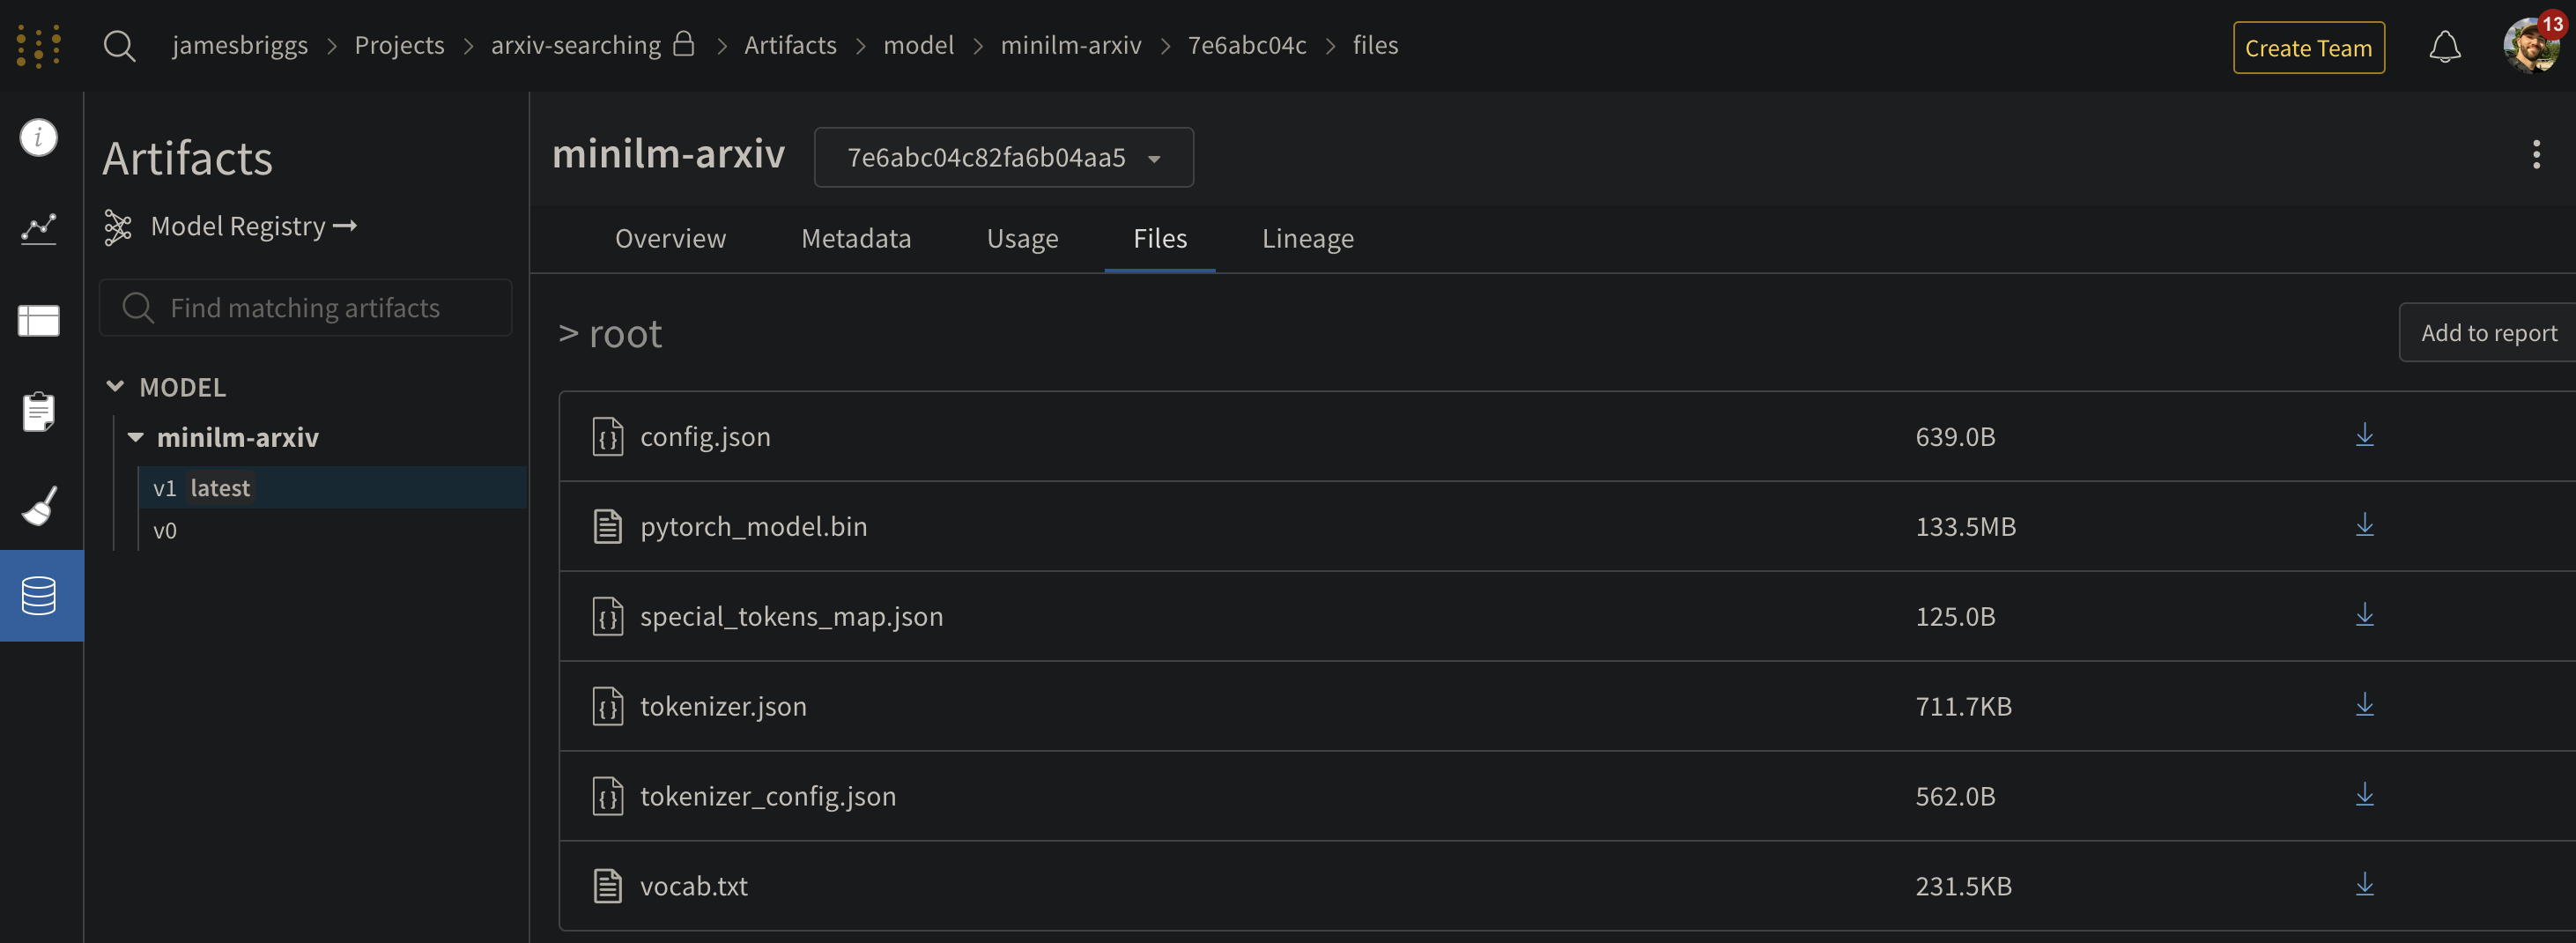

With that we're ready to move on to the next notebook [`02-encode.ipynb`](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/projects/training-with-wandb/02-encode.ipynb).